In [2]:
import numpy as np
import PIL.Image
import tensorflow as tf
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [3]:
train_data_dir = pathlib.Path('waste_dataset/TRAIN')
valid_data_dir = pathlib.Path('waste_dataset/VALID')

Found 2141 files belonging to 2 classes.
Found 42 files belonging to 2 classes.
['electronic_non_waste', 'electronic_waste']


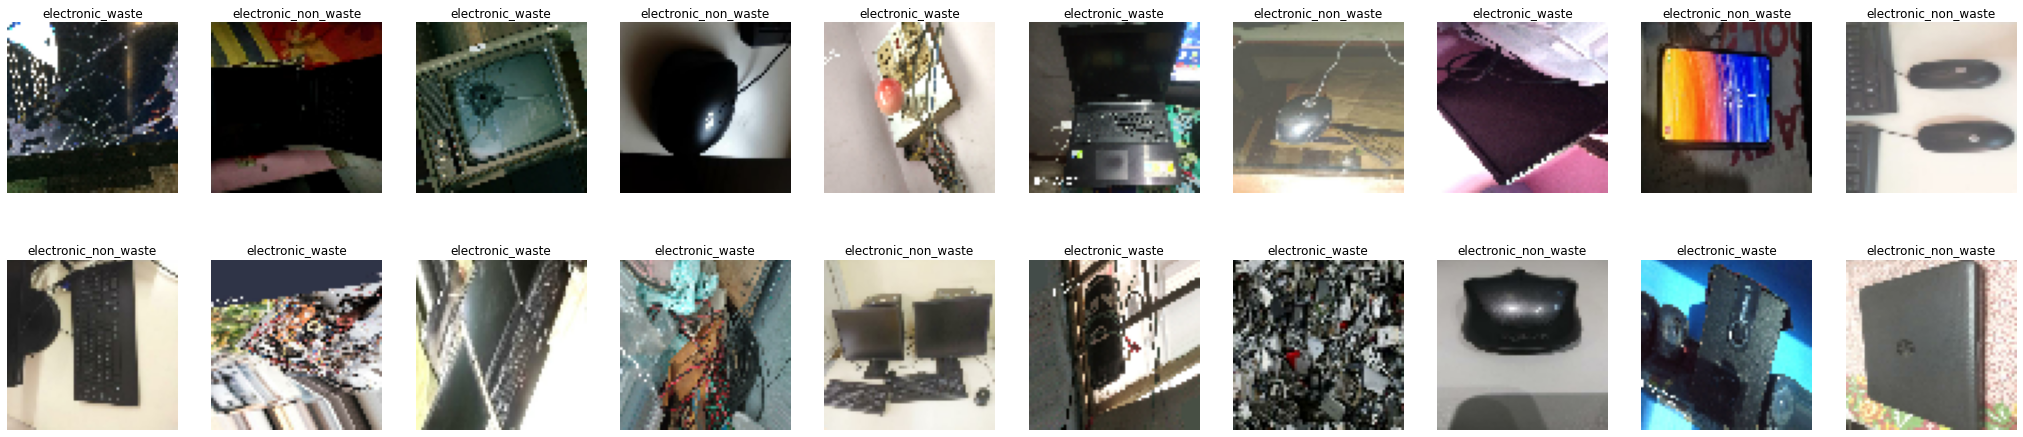

In [4]:
batch_size = img_height = img_width = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_data_dir,
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)
plt.figure(figsize=(36,8))

for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(2,10,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    
def Convert(string):
    li = list(string.split(" "))
    return li
Y_list = []
for _ , labels in val_ds:
  Y_list.append(labels)
all = []
for y in Y_list:
    s = str(y)
    ls = Convert(s)
    all.append(ls)
main_y= []
for i, v in enumerate(str(all)):
    if v == "0" or v == "1":
        main_y.append(int(v))

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

(64, 64, 64, 3)
(64,)
(42, 64, 64, 3)
(42,)
0.0 0.95588243


In [6]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
result = model.fit(train_ds, validation_data=val_ds, epochs = 100)

Epoch 1/100
34/34 [==============================] - 35s 901ms/step - loss: 11.4405 - accuracy: 0.5907 - val_loss: 0.3364 - val_accuracy: 0.8810
Epoch 2/100
34/34 [==============================] - 9s 274ms/step - loss: 0.4153 - accuracy: 0.8282 - val_loss: 0.2515 - val_accuracy: 0.9286
Epoch 3/100
34/34 [==============================] - 9s 280ms/step - loss: 0.2856 - accuracy: 0.8769 - val_loss: 0.1767 - val_accuracy: 0.9286
Epoch 4/100
34/34 [==============================] - 10s 283ms/step - loss: 0.2638 - accuracy: 0.8936 - val_loss: 0.2124 - val_accuracy: 0.8571
Epoch 5/100
34/34 [==============================] - 9s 275ms/step - loss: 0.2271 - accuracy: 0.9159 - val_loss: 0.1224 - val_accuracy: 0.9524
Epoch 6/100
34/34 [==============================] - 9s 277ms/step - loss: 0.2280 - accuracy: 0.9013 - val_loss: 0.1651 - val_accuracy: 0.9048
Epoch 7/100
34/34 [==============================] - 10s 295ms/step - loss: 0.1821 - accuracy: 0.9275 - val_loss: 0.1787 - val_accuracy: 0.

1/1 [==============================] - 0s 41ms/step - loss: 0.0077 - accuracy: 1.0000
Accuracy:  100.0 %
(42,)


<AxesSubplot:title={'center':'Confusion Matrix'}>

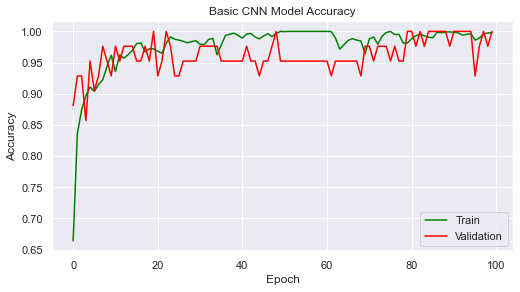

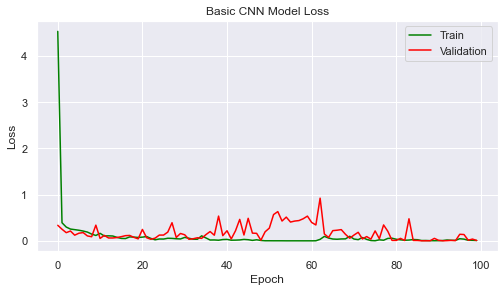

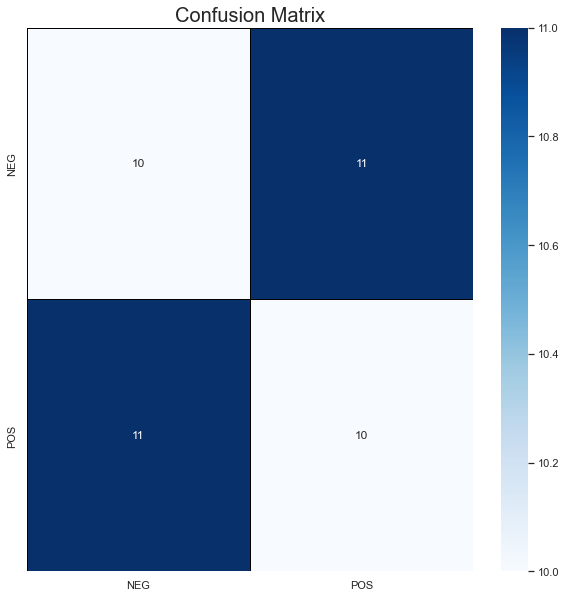

In [7]:
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(result.history['accuracy'], color="green")
plt.plot(result.history['val_accuracy'] , color="red")
plt.title('Basic CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(result.history['loss'], color="green")
plt.plot(result.history['val_loss'], color="red")
plt.title('Basic CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
score = model.evaluate(val_ds,use_multiprocessing=True,workers=10)
print("Accuracy: ",np.round(score[1]*100,3),"%")
# print(len(main_y))
testX_arg = np.argmax(val_ds)
y_pred = np.argmax(model.predict(val_ds), axis=1)
y_true = np.argmax(val_ds)
print(y_pred.shape)
cm = confusion_matrix(main_y,y_pred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
ct= ["NEG","POS"]
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)